<a href="https://colab.research.google.com/github/CorentinMAG/AI/blob/master/keras_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Analyse de sentiments

On va utiliser le jeu de données [Large Movie Review](https://ai.stanford.edu/~amaas/data/sentiment/) qui contient le texte de 50 000 critiques de films. Ce jeu de données est divisé en :
* 25 000 évaluations pour la formation
* 25 000 évaluations pour les tests. 

Les ensembles de formation et de test sont équilibrés , ce qui signifie qu'ils contiennent un nombre égal d'avis positifs et négatifs.

**Le but est de classer les critiques de film comme positives ou négatives** 

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

#on télécharge l'archive compressé
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 6s 0us/step


In [23]:
os.listdir(dataset_dir)

['README', 'train', 'test', 'imdbEr.txt', 'imdb.vocab']

In [29]:
train_dir = os.path.join(dataset_dir,'train')

#dossier inutile
#remove_dir = os.path.join(train_dir, 'unsup')
#shutil.rmtree(remove_dir)

#les dossiers pos et neg contiennent de nombreuses critiques de films
print(os.listdir(train_dir))

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())



['unsupBow.feat', 'urls_pos.txt', 'neg', 'urls_unsup.txt', 'urls_neg.txt', 'pos', 'labeledBow.feat']
Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Charger les données

Pour charger les données du disque et les préparer dans un format adapté, on va utiliser la fonction : 


```
# tf.keras.preprocessing.text_dataset_from_directory()
```

La structure des dossiers doit être la suivante : 

>main_directory/  
>...class_a/  
>......a_text_1.txt  
>......a_text_2.txt  
>...class_b/  
>......b_text_1.txt  
>......b_text_2.txt  

Lors de l'exécution d'une expérience d'apprentissage automatique, il est recommandé de diviser votre ensemble de données en trois divisions:
* entraînement
* validation
* test

L'ensemble de données IMDB a déjà été divisé en train et test, mais il lui manque un ensemble de validation. Créons un ensemble de validation en utilisant une division 80:20 des données d'entraînement.



In [30]:
batch_size = 32
seed = 42

#ensemble qui servira pour le test (20 000 = 80% de l'ensemble de train = 25 000)
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [32]:
#on parcours quelques données...
#les labels sont 0 ou 1
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
print("Label 0 correspond à", raw_train_ds.class_names[0])
print("Label 1 correspond à", raw_train_ds.class_names[1])

Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

In [33]:
#on crée un ensemble de valisation (5 000 fichiers)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [34]:
#on crée un dataset avec les fichiers dans le dossier test
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Préparer l'ensemble de données pour la formation

On va standardiser, tokeniser et vectoriser les données à l'aide de la couche `tf.keras.layers.experimental.preprocessing.TextVectorization()`

* **La normalisation** fait référence au prétraitement du texte, généralement pour supprimer la ponctuation ou les éléments HTML pour simplifier l'ensemble de données. 
* **La tokenisation** fait référence à la division de chaînes en jetons (par exemple, la division d'une phrase en mots individuels, en la fractionnant sur des espaces). 
* **La vectorisation** fait référence à la conversion de jetons en nombres afin qu'ils puissent être introduits dans un réseau neuronal. 


In [39]:
#on crée une fonction pour retirer le HTML des critiques car la couche TextVectorisation ne le fait pas
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [40]:
max_features = 10000
sequence_length = 250

#on standardise, tokenise et vectorise nos données
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Ensuite, il faut appeler la méthode `adapt()` pour que l'état de la couche puisse être appliqué aux données

In [70]:
#on enlève les labels, car c'est uniquement les critiques qui doivent être transformées par la couche
train_text = raw_train_ds.map(lambda x, y: x)

#il est important d'apeller adapt() sur les données d'entrainement et pas un autre dataset
vectorize_layer.adapt(train_text)

#fonction pour voir le résultat de la couche TextVectorisation pour prétraiter certaines données
def vectorize_text(text, label):
  #notre text est transformé en un tenseur de forme (1,)
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

#récupère un lot de 32 critiques et leur label du dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

#chaque critique étant normalisé, puis tokenisé puis vectorisé,
#la fonction get_vocabulary() permet à partir d'un entier de retrouver le token (chaine)
print(vectorize_layer.get_vocabulary()[1287])

Review tf.Tensor(b'The Last Hunt is the forgotten Hollywood classic western. The theme of genocide via buffalo slaughter is present in other films but never so savagely. Robert Taylor\'s against-type role as the possessed buffalo and Indian killer is his finest performance.<br /><br />In the 1950s, your mom dropped you and your friends off at the Saterday matin\xc3\xa9e, usually featuring a western or comedy. But it was wrong then and now to let a youngster watch psycho-dramas like The Searchers and The Last Hunt. Let the kids wait a few years before exposing them to films with repressed sexual sadism and intense racial hatred.<br /><br />Why did Mom fail to censor these films? Because they featured "safe" Hollywood stars like Taylor and John Wayne. But the climatic scene in The Last Hunt is as horrifying as Vincent Price\'s mutation in The Fly.<br /><br />The mythology of the white buffalo, part of the texture of this movie, was later ripped-off by other movies including The White Buf

Enfin, on applique la couche TextVectorisation à l'ensemble des données

In [61]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configurer l'ensemble de données pour les performances

Ce sont deux méthodes importantes que vous devez utiliser lors du chargement de données pour vous assurer que les E / S ne deviennent pas bloquantes.

* `.cache()` garde les données en mémoire après leur chargement hors du disque. Cela garantira que l'ensemble de données ne deviendra pas un goulot d'étranglement lors de l'entraînement de votre modèle. Si votre ensemble de données est trop volumineux pour tenir dans la mémoire, vous pouvez également utiliser cette méthode pour créer un cache sur disque performant, qui est plus efficace à lire que de nombreux petits fichiers.

* `.prefetch()` chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement.

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Créer le modèle

In [73]:
embedding_dim = 16

model = tf.keras.Sequential([
                             
  #cette couche prend les critiques encodées en entier et recherche un vecteur d'incorporation (de taille 16) 
  #pour chaque entier (donc pour chaque mot)
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  #cette couche renvoie un vecteur de longueur fixe. Cela permet au modèle de gérer des entrées de longueur variable, 
  #de la manière la plus simple possible
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Fonction de perte et optimiseur

Un modèle a besoin d'une fonction de perte et d'un optimiseur pour l'entraînement

In [74]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Former le modèle 

On entraine le modèle en passant le dataset à la méthode `fit()`

In [75]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 21ms/step - loss: 0.6628 - binary_accuracy: 0.6970 - val_loss: 0.6138 - val_binary_accuracy: 0.7752
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5481 - binary_accuracy: 0.8033 - val_loss: 0.4978 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4450 - binary_accuracy: 0.8450 - val_loss: 0.4197 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3780 - binary_accuracy: 0.8658 - val_loss: 0.3735 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3355 - binary_accuracy: 0.8799 - val_loss: 0.3445 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3041 - binary_accuracy: 0.8907 - val_loss: 0.3256 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

# Evaluer le modèle

Deux valeurs sont renvoyés, la perte et la précision

In [76]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 15ms/step - loss: 0.3098 - binary_accuracy: 0.8749
Loss:  0.3097951412200928
Accuracy:  0.8748800158500671


# Créer un graphique de précision et de perte au fil du temps

`model.fit()` retourne un objet History qui contient un dictionnaire avec tout ce qui s'est passé pendant l'entraînement:

In [77]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Il y a quatre entrées: une pour chaque métrique surveillée pendant la formation et la validation. On peux les utiliser pour tracer la perte de formation et de validation à des fins de comparaison, ainsi que la précision de la formation et de la validation

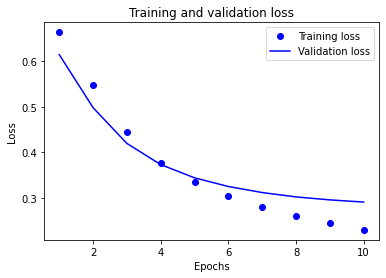

In [78]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

On note que la perte diminue à chaque epoque

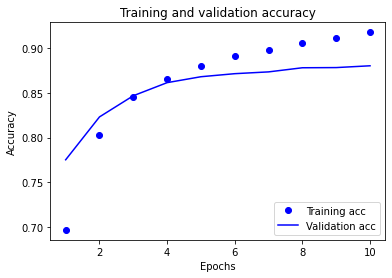

In [79]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

La précision augmente à chaque époque
Pour les deux graphes, on voit que validation loss est plus élevé que training loss de même pour validation acc.

C'est un exemple de sur-entrainement: le modèle fonctionne mieux sur les données d'entraînement que sur les données qu'il n'a jamais vues auparavant

# Exporter le modèle

Dans le code ci-dessus, on a appliqué la couche TextVectorization au jeu de données avant d'alimenter le modèle en texte. Si on souhaite rendre le modèle capable de traiter des chaînes brutes (par exemple, pour simplifier son déploiement), on peut inclure la couche TextVectorization dans le modèle. Pour ce faire, on doit créer un nouveau modèle.

In [80]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 13ms/step - loss: 0.3098 - accuracy: 0.8749
0.8748800158500671
